# 1.1 Curating external datasets
### Background
Data tends to be scarce and sparse in the biochemistry world. Due to the time consuming and costly nature of lab experiments, it is not always feasible to generate the tens to hundreds of thousands of data points potentially needed to train machine learning models (depending on the complexity of the model and the nature of the data). We therefore want to be able to supplement our model training with data from external, publicly available sources, such as PubChem, ChEMBL, Uniprot, etc.  

To make these datasets amenable to training, they have to be processed and cleaned. This protocol will walk you through necessary bare minimum data transformation and cleaning that your external data has to undergo to be amenable to modeling.  

**NOTE**: There is no real one-size-fits-all approach to data curation given the variety of use cases. Some experimentation and iteration 
may be necessary.  Additionally this represents the **MINIMUM** level of curation needed to get a dataset like this fed into a machine learning model. Additional processing steps (normalization, outlier detection etc) are likely required to get build the best models possible. 


### Requirements
For this process in general, you need an external dataset that is in a file format readable by `pandas`, e.g. `.csv`, `.parquet`, `.xlsx`, `.xls`. The dataset must, at minimum, include:  
1. a column of SMILES strings  
2. a column of compound activity measured as one of the following: `'IC50', 'XC50', 'EC50', 'AC50', 'Ki', 'Kd', 'Potency'`  

## 1. Overview
In this demo notebook, we'll show you how to process a datasets from two open source repositories: PubChem and ChEMBL.  

## 2. Curating a Pubchem dataset
First, we'll clean a dataset of small molecule activity against human pregnane X receptor, or PXR, from ChEMBL for modeling with the Anvil workflow.  

This dataset is provided in `raw_data/ChEMBL_permissive_PXR_CHEMBL3401_raw.parquet`.  

In [2]:
from openadmet.toolkit.chemoinformatics.data_curation import CSVProcessing
import numpy as np

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  # Silence logger messages from RDKit

### 2.1. Read in the data and create a column of canonical SMILES strings
We read in the data and use `MultiDataProcessing` to create several new columns:
- `OPENADMET_CANONICAL_SMILES` is as close to a standardized or canonical SMILES string we can obtain for a molecular compound. The raw data is likely to contain various SMILES strings for the same compound. We want to standardize these to a single SMILES string if possible.  
- `OPENADMET_INCHIKEY` is a unique value associated with a given compound. Use this value when checking for duplicate rows or replicates. 
- `OPENADMET_LOGAC50` is the numerical activity value our model will be trained to predict.
- `OPENADMET_ACTIVITY_TYPE` is the specific activity type of `OPENADMET_LOGAC50`. For example, this could be EC50, IC50, XC50, Ki, Kd, Potency, etc.
These columns are essential for the Anvil workflow.  

The below cell may take a couple of minutes to run.

In [ ]:
# Read in the data
df = MultiDataProcessing.read_file("./raw_data/ChEMBL_permissive_PXR_CHEMBL3401_raw.parquet")

# Now instantiate a processor class
processor = CSVProcessing()

# Use the processor to create a standardized or canonical SMILES string and unique INCHIKEY value
processed_data = processor.standardize_smiles_and_convert(data=df)
processed_data[['OPENADMET_CANONICAL_SMILES', 'INCHIKEY']]

,OPENADMET_CANONICAL_SMILES,INCHIKEY
3,CC[C@H]1CN2CCC3=CC(OC)=C(OC)C=C3[C@@H]2C[C@@H]...,AUVVAXYIELKVAI-CKBKHPSWSA-N
4,C[C@@]12C(=O)OC(=O)[C@]1(C)C1CCC2O1,DHZBEENLJMYSHQ-OBDNUKKESA-N
5,N=C(NC1=CC=CC=C1)NC1=CC=CC=C1,OWRCNXZUPFZXOS-UHFFFAOYSA-N
6,C=CC(=O)NC1=CC2=C(NC3=CC=C(F)C(Cl)=C3)N=CN=C2C...,OMZCMEYTWSXEPZ-UHFFFAOYSA-N
7,O=C1C=C(C2=CC=C(O)C=C2)OC2=CC(O)=CC(O)=C12,KZNIFHPLKGYRTM-UHFFFAOYSA-N
...,...,...
9665,C1CCSC1,RAOIDOHSFRTOEL-UHFFFAOYSA-N
9666,CN(CCCC(O)C1=CC=CN=C1)N=O,OGRXKBUCZFFSTL-UHFFFAOYSA-N
9667,OCCN1CN(CCO)CN(CCO)C1,HUHGPYXAVBJSJV-UHFFFAOYSA-N
9668,CN(CCCC(=O)C1=CC=CN=C1)N=O,FLAQQSHRLBFIEZ-UHFFFAOYSA-N


### 2.2. Calculate LOGAC50 from activity values
LogAC50 or pAC50 is a standardized activity value and the value that our ADMET models predict. It is the negative log10 of your activity value M. With this PXR dataset, the activity value is EC50. However, you can similarly standardize via the negative log10 with IC50, XC50, etc. as well. If you're interested, you can read up further on logAC50 values [here](https://www.collaborativedrug.com/cdd-blog/why-changing-from-ic50-to-pic50-will-change-your-life).

Here, we create a new column, `OPENADMET_LOGAC50` that is the negative log10 of the `Agonist Potency (uM)`.

In [3]:
pubchem_data["OPENADMET_LOGAC50"] = -np.log10(pubchem_data["Agonist Potency (uM)"].astype(float)*1e-6)
pubchem_data[["OPENADMET_CANONICAL_SMILES", "INCHIKEY", "OPENADMET_LOGAC50"]]

,OPENADMET_CANONICAL_SMILES,INCHIKEY,OPENADMET_LOGAC50
3,CC[C@H]1CN2CCC3=CC(OC)=C(OC)C=C3[C@@H]2C[C@@H]...,AUVVAXYIELKVAI-CKBKHPSWSA-N,7.475066
4,C[C@@]12C(=O)OC(=O)[C@]1(C)C1CCC2O1,DHZBEENLJMYSHQ-OBDNUKKESA-N,5.991733
5,N=C(NC1=CC=CC=C1)NC1=CC=CC=C1,OWRCNXZUPFZXOS-UHFFFAOYSA-N,5.312700
6,C=CC(=O)NC1=CC2=C(NC3=CC=C(F)C(Cl)=C3)N=CN=C2C...,OMZCMEYTWSXEPZ-UHFFFAOYSA-N,4.958399
7,O=C1C=C(C2=CC=C(O)C=C2)OC2=CC(O)=CC(O)=C12,KZNIFHPLKGYRTM-UHFFFAOYSA-N,4.647075
...,...,...,...
9665,C1CCSC1,RAOIDOHSFRTOEL-UHFFFAOYSA-N,NaN
9666,CN(CCCC(O)C1=CC=CN=C1)N=O,OGRXKBUCZFFSTL-UHFFFAOYSA-N,NaN
9667,OCCN1CN(CCO)CN(CCO)C1,HUHGPYXAVBJSJV-UHFFFAOYSA-N,NaN
9668,CN(CCCC(=O)C1=CC=CN=C1)N=O,FLAQQSHRLBFIEZ-UHFFFAOYSA-N,NaN


These three columns: `OPENADMET_CANONICAL_SMILES`, `OPENADMET_LOGAC50`, and `INCHIKEY`, are the minimum columns required to train a model with Anvil.  

### 2.3. Additional data cleaning, dependent on use-case
Additional data cleaning and processing is dependent on your use case, but here are some general guidelines:
- Remove rows with `NaN` values for `OPENADMET_LOGAC50`  
- Average together both technical replicates and biological replicates for pAC50 values by `INCHIKEY`
- Check distribution of pAC50 values or other values of interest for further guidance on data cleaning


In [4]:
# Remove NaN rows
pubchem_data = pubchem_data.dropna(subset=["OPENADMET_LOGAC50"])
pubchem_data

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Activity Summary,Agonist Activity,Agonist Potency (uM),Agonist Efficacy (%),Viability Activity,Viability Potency (uM),Viability Efficacy (%),Sample Source,OPENADMET_CANONICAL_SMILES,INCHIKEY,OPENADMET_LOGAC50
3,1,170465705.0,10219.0,CC[C@H]1CN2CCC3=CC(=C(C=C3[C@@H]2C[C@@H]1C[C@@...,Active,100.0,NaN,NaN,active agonist,active agonist,0.03349146,211.4194337,active antagonist,0.037578,-58.1492,Enzo,CC[C@H]1CN2CCC3=CC(OC)=C(OC)C=C3[C@@H]2C[C@@H]...,AUVVAXYIELKVAI-CKBKHPSWSA-N,7.475066
4,2,170465704.0,6708701.0,C[C@]12C3CCC([C@]1(C(=O)OC2=O)C)O3,Active,99.0,NaN,NaN,active agonist,active agonist,1.01921876,362.3484966,active antagonist,0.237101,-73.1631,Enzo,C[C@@]12C(=O)OC(=O)[C@]1(C)C1CCC2O1,DHZBEENLJMYSHQ-OBDNUKKESA-N,5.991733
5,3,144214002.0,7594.0,C1=CC=C(C=C1)NC(=NC2=CC=CC=C2)N,Active,93.0,NaN,NaN,active agonist,active agonist,4.86743404,489.9294473,active antagonist,5.6492,-54.6079,SIGMA,N=C(NC1=CC=CC=C1)NC1=CC=CC=C1,OWRCNXZUPFZXOS-UHFFFAOYSA-N,5.312700
6,4,144206912.0,156414.0,C=CC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=C(C=C...,Active,91.0,NaN,NaN,active agonist,active agonist,11.00527102,655.906322,active antagonist,2.87255,-44.3797,Selleck,C=CC(=O)NC1=CC2=C(NC3=CC=C(F)C(Cl)=C3)N=CN=C2C...,OMZCMEYTWSXEPZ-UHFFFAOYSA-N,4.958399
7,5,144213201.0,5280443.0,C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O,Active,90.0,NaN,NaN,active agonist,active agonist,22.53850342,949.4401877,active antagonist,27.5955,-72.5478,LightBiologicals,O=C1C=C(C2=CC=C(O)C=C2)OC2=CC(O)=CC(O)=C12,KZNIFHPLKGYRTM-UHFFFAOYSA-N,4.647075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3503,3501,144212925.0,18669.0,CCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC.[Br-],Inconclusive,10.0,NaN,NaN,inconclusive antagonist,inconclusive antagonist,30.63785871,-41.13657327,active antagonist,27.5955,-105.769,SIGMA,CCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC,QQJDHWMADUVRDL-UHFFFAOYSA-N,4.513742
3504,3502,170465208.0,11626384.0,C1CC2=C(C=CC(=C2)F)O[C@H]1[C@H](CNC[C@@H]([C@@...,Inconclusive,10.0,NaN,NaN,inconclusive antagonist,inconclusive antagonist,35.47595334,-51.18281375,active antagonist,28.7255,-114.974,Sequoia,O[C@@H](CNC[C@H](O)[C@H]1CCC2=CC(F)=CC=C2O1)[C...,KOHIRBRYDXPAMZ-YHDSQAASSA-N,4.450066
3505,3503,144207380.0,62857.0,CNCCC(C1=CC=CC=C1)OC2=CC=C(C=C2)C(F)(F)F.Cl,Inconclusive,10.0,NaN,NaN,inconclusive antagonist,inconclusive antagonist,42.70561957,-42.12743618,active antagonist,24.0151,-96.9275,TCI,CNCCC(OC1=CC=C(C(F)(F)F)C=C1)C1=CC=CC=C1,RTHCYVBBDHJXIQ-UHFFFAOYSA-N,4.369515
3506,3504,144210964.0,77406.0,C1=C(OC(=C1)[N+](=O)[O-])C2=NN=C(O2)N,Inconclusive,10.0,NaN,NaN,inconclusive antagonist,inconclusive antagonist,54.48267331,-77.01353434,active antagonist,25.2886,-99.7031,SIGMA,NC1=NN=C(C2=CC=C([N+](=O)[O-])O2)O1,VTWQUFUBSCXPOW-UHFFFAOYSA-N,4.263742


In [5]:
# Average together pAC50 values for compounds with the same INCHIKEY
pubchem_agg_data = pubchem_data.groupby("INCHIKEY", as_index=False).agg({
    "OPENADMET_LOGAC50": "mean",
    "OPENADMET_CANONICAL_SMILES": "first"
})
pubchem_agg_data

,INCHIKEY,OPENADMET_LOGAC50,OPENADMET_CANONICAL_SMILES
0,AADCDMQTJNYOSS-LBPRGKRZSA-N,4.725066,CCC1=CC(Cl)=C(OC)C(C(=O)NC[C@@H]2CCCN2CC)=C1O
1,AAEVYOVXGOFMJO-UHFFFAOYSA-N,4.548181,CSC1=NC(NC(C)C)=NC(NC(C)C)=N1
2,AAKJLRGGTJKAMG-UHFFFAOYSA-N,4.991733,C#CC1=CC=CC(NC2=NC=NC3=CC(OCCOC)=C(OCCOC)C=C23...
3,AAOVKJBEBIDNHE-UHFFFAOYSA-N,4.499446,CN1C(=O)CN=C(C2=CC=CC=C2)C2=CC(Cl)=CC=C21
4,AAPVQEMYVNZIOO-UHFFFAOYSA-N,4.663742,O=S1(=O)OCC2C(CO1)C1(Cl)C(Cl)=C(Cl)C2(Cl)C1(Cl)Cl
...,...,...,...
2343,ZZMVLMVFYMGSMY-UHFFFAOYSA-N,5.004638,CC(C)CC(C)NC1=CC=C(NC2=CC=CC=C2)C=C1
2344,ZZVUWRFHKOJYTH-UHFFFAOYSA-N,4.323159,CN(C)CCOC(C1=CC=CC=C1)C1=CC=CC=C1
2345,ZZYASVWWDLJXIM-UHFFFAOYSA-N,4.608399,CC(C)(C)C1=CC(=O)C(C(C)(C)C)=CC1=O
2346,ZZYSLNWGKKDOML-UHFFFAOYSA-N,4.647075,CCC1=NN(C)C(C(=O)NCC2=CC=C(C(C)(C)C)C=C2)=C1Cl


Text(0.5, 1.0, 'Distribution of pAC50 of PXR')

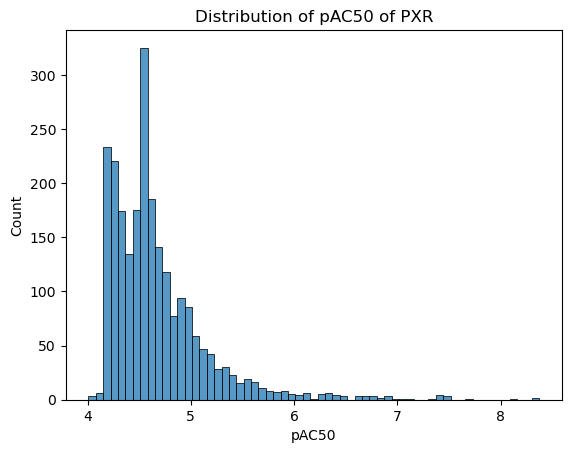

In [6]:
# Check the distribution of your data

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=pubchem_agg_data, x="OPENADMET_LOGAC50")
plt.xlabel("pAC50")
plt.title("Distribution of pAC50 of PXR")

### 2.4. Save the cleaned and processed data
Congrats! You now have a dataset ready for model training with Anvil.

In [7]:
pubchem_agg_data.to_parquet("./processed_data/processed_PXR_pubchem.parquet", index=False)

## 3. Curating a ChEMBL dataset

Now, we'll go over how you may use the toolkit process a dataset from ChEMBL. We will similarly focus on activity data for PXR.  

### 3.1. Read in the data from ChEMBL downloader
Our toolkit includes automatic handling of the ChEMBL database. You can access ChEMBL's data **without** manually downloading a `.csv` file from the ChEMBL website.


In [8]:
from openadmet.toolkit.database.chembl import PermissiveChEMBLTargetCurator

chembl_version = 35 # Specify which version of the ChEMBL database you're accessing. 35 is the latest version as of 7/1/25
target = "CHEMBL3401" # Specify the ChEMBL ID for PXR. This needs to be looked up on the ChEMBL website

# Instantiate the curator. This will automatically handle downloading the ChEMBL database
curator = PermissiveChEMBLTargetCurator(chembl_version=chembl_version, chembl_target_id=target)

# Load the activity data into a dataframe
chembl_df = curator.get_activity_data()
chembl_df

/Users/cynthiaxu/miniconda3/envs/openadmet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,assay_id,doc_id,standard_value,molregno,canonical_smiles,standard_inchi_key,tid,target_chembl_id,pchembl_value,compound_name,...,variant_id,doc_year,doc_journal,doc_doi,doc_title,doc_authors,doc_abstract,doc_patent_id,doc_pubmed_id,doc_chembl_release_id
0,2279561,125443,26.0,92776,O=S(=O)(c1ccccc1)N(CC(F)(F)F)c1ccc(C(O)(C(F)(F...,SGIWFELWJPNFDH-UHFFFAOYSA-N,11912,CHEMBL3401,7.58,T091317,...,<NA>,2022,J Med Chem,10.1021/acs.jmedchem.2c01640,"Design and Optimization of 1<i>H</i>-1,2,3-Tri...","Li Y, Lin W, Chai SC, Wu J, Annu K, Chen T.",The pregnane X receptor (PXR) is a key regulat...,None,36480704,34
1,2279561,125443,210.0,2833873,COc1ccc(OC)c(-n2nnc(S(=O)(=O)Nc3ccc(C(C)(C)C)c...,HQOMOZQNGSURDN-UHFFFAOYSA-N,11912,CHEMBL3401,6.68,None,...,<NA>,2022,J Med Chem,10.1021/acs.jmedchem.2c01640,"Design and Optimization of 1<i>H</i>-1,2,3-Tri...","Li Y, Lin W, Chai SC, Wu J, Annu K, Chen T.",The pregnane X receptor (PXR) is a key regulat...,None,36480704,34
2,2279561,125443,1200.0,2797120,COc1ccc(OC)c(-n2nnc(C(=O)Nc3ccc(C(C)(C)C)cc3)c...,KRIYUNKTWVXQOC-UHFFFAOYSA-N,11912,CHEMBL3401,5.92,None,...,<NA>,2022,J Med Chem,10.1021/acs.jmedchem.2c01640,"Design and Optimization of 1<i>H</i>-1,2,3-Tri...","Li Y, Lin W, Chai SC, Wu J, Annu K, Chen T.",The pregnane X receptor (PXR) is a key regulat...,None,36480704,34
3,2279561,125443,650.0,2792747,COc1ccc(OC)c(-n2nnc(C(=O)Nc3cccc(C(C)(C)C)c3)c...,PCYGLTBEVVCTSX-UHFFFAOYSA-N,11912,CHEMBL3401,6.19,None,...,<NA>,2022,J Med Chem,10.1021/acs.jmedchem.2c01640,"Design and Optimization of 1<i>H</i>-1,2,3-Tri...","Li Y, Lin W, Chai SC, Wu J, Annu K, Chen T.",The pregnane X receptor (PXR) is a key regulat...,None,36480704,34
4,2279561,125443,2970.0,2800146,COc1ccc(OC)c(-n2nnc(C(=O)Nc3ccccc3C(C)(C)C)c2C)c1,VTTAHBDGCKLNOT-UHFFFAOYSA-N,11912,CHEMBL3401,5.53,None,...,<NA>,2022,J Med Chem,10.1021/acs.jmedchem.2c01640,"Design and Optimization of 1<i>H</i>-1,2,3-Tri...","Li Y, Lin W, Chai SC, Wu J, Annu K, Chen T.",The pregnane X receptor (PXR) is a key regulat...,None,36480704,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,2060644,118864,10000.0,2537938,CN[C@H](CNc1cc(F)c(S(=O)(=O)Nc2ncc(F)s2)cc1Cl)...,UQHXPIBAOGSNET-JTQLQIEISA-N,11912,CHEMBL3401,5.00,None,...,<NA>,2021,ACS Med Chem Lett,10.1021/acsmedchemlett.1c00218,Discovery of Arylsulfonamide Na1.7 Inhibitors:...,"Roecker AJ,Layton ME,Pero JE,Kelly MJ,Greshock...",The voltage-gated sodium channel Na1.7 continu...,None,34141090,30
1398,2149721,121631,7700.0,2517372,O=C1c2nc3ccccc3n2CCN1CCCCOc1ccc(OC(F)(F)F)cc1,QRCUMXUPIXTGPF-UHFFFAOYSA-N,11912,CHEMBL3401,5.11,None,...,<NA>,2021,J Med Chem,10.1021/acs.jmedchem.1c00563,Fragment-Based Optimization of Dihydropyrazino...,"Szabó G, Erdélyi P, Kolok S, Vastag M, Halász ...",Our previous scaffold-hopping attempts resulte...,None,34080424,32
1399,2165788,122079,18000.0,2723599,CC(C)O[C@H]1CC[C@H](C(=O)N2Cc3cccnc3Nc3ccc(N4C...,UFGROHQRASPGIZ-BBLPBDBVSA-N,11912,CHEMBL3401,4.75,None,...,<NA>,2022,ACS Med Chem Lett,10.1021/acsmedchemlett.2c00089,Diminishing GSH-Adduct Formation of Tricyclic ...,"Huang C, Fischer C, Machacek MR, Bogen S, Bift...",Mutant isocitrate dehydrogenase 1 (IDH1) has b...,None,35450359,32
1400,2165788,122079,3200.0,2727966,O=C(C1CCc2ccccc2CC1)N1Cc2cccnc2Nc2ccc(N3CCOCC3...,ZGJIUUQQZUDAKL-UHFFFAOYSA-N,11912,CHEMBL3401,5.50,None,...,<NA>,2022,ACS Med Chem Lett,10.1021/acsmedchemlett.2c00089,Diminishing GSH-Adduct Formation of Tricyclic ...,"Huang C, Fischer C, Machacek MR, Bogen S, Bift...",Mutant isocitrate dehydrogenase 1 (IDH1) has b...,None,35450359,32


### 3.2. Create a column of canonical smiles
As with the PubChem processing, we now want to create a column of canonicalized SMILES strings with associated INCHIKEYs.  

You'll notice that the ChEMBL data has its own `canonical_smiles` and `standard_inchi_key` columns. These are slightly different from how our toolkit creates these columns and to maintain data handling consistency across multiple sources, we still want to create the `OPENADMET_CANONICAL_SMILES` and `INCHIKEY` columns with our toolkit functions.

In [9]:
# Now instantiate a processor class
processor2 = CSVProcessing(smiles_col="canonical_smiles") # In this particular dataset, there are multiple columns that contain SMILES strings, so we need to specify the column we want for canonicalization

# Use the processor to create a standardized or canonical SMILES string and unique INCHIKEY value
chembl_data = processor2.standardize_smiles_and_convert(data=chembl_df)
chembl_data[['OPENADMET_CANONICAL_SMILES', 'INCHIKEY']]

,OPENADMET_CANONICAL_SMILES,INCHIKEY
0,O=S(=O)(C1=CC=CC=C1)N(CC(F)(F)F)C1=CC=C(C(O)(C...,SGIWFELWJPNFDH-UHFFFAOYSA-N
1,COC1=CC=C(OC)C(N2N=NC(S(=O)(=O)NC3=CC=C(C(C)(C...,HQOMOZQNGSURDN-UHFFFAOYSA-N
2,COC1=CC=C(OC)C(N2N=NC(C(=O)NC3=CC=C(C(C)(C)C)C...,KRIYUNKTWVXQOC-UHFFFAOYSA-N
3,COC1=CC=C(OC)C(N2N=NC(C(=O)NC3=CC=CC(C(C)(C)C)...,PCYGLTBEVVCTSX-UHFFFAOYSA-N
4,COC1=CC=C(OC)C(N2N=NC(C(=O)NC3=CC=CC=C3C(C)(C)...,VTTAHBDGCKLNOT-UHFFFAOYSA-N
...,...,...
1397,CN[C@H](CNC1=CC(F)=C(S(=O)(=O)NC2=NC=C(F)S2)C=...,UQHXPIBAOGSNET-JTQLQIEISA-N
1398,O=C1C2=NC3=CC=CC=C3N2CCN1CCCCOC1=CC=C(OC(F)(F)...,QRCUMXUPIXTGPF-UHFFFAOYSA-N
1399,CC(C)O[C@H]1CC[C@H](C(=O)N2CC3=CC=CN=C3NC3=CC=...,UFGROHQRASPGIZ-BBLPBDBVSA-N
1400,O=C(C1CCC2=CC=CC=C2CC1)N1CC2=CC=CN=C2NC2=CC=C(...,ZGJIUUQQZUDAKL-UHFFFAOYSA-N


### 3.3. Rename LOGAC50 value
ChEMBL does its own processing and curation of activity data to output a `pChEMBL` value which is the equivalent of `LOGAC50` value that we previously calculated with the PubChem data. We therefore do not need to do any new calculations and will just rename the `pchembl_value` column to `OPENADMET_LOGAC50` again, for data consistency.  

Notice we now have created the same 3 main columns with our ChEMBL data as with our PubChem data:
- `OPENADMET_CANONICAL_SMILES`
- `INCHIKEY`
- `OPENADMET_LOGAC50`

In [10]:
chembl_data = chembl_data.rename(columns={"pchembl_value": "OPENADMET_LOGAC50"})

chembl_data[["OPENADMET_CANONICAL_SMILES", "INCHIKEY", "OPENADMET_LOGAC50"]]

,OPENADMET_CANONICAL_SMILES,INCHIKEY,OPENADMET_LOGAC50
0,O=S(=O)(C1=CC=CC=C1)N(CC(F)(F)F)C1=CC=C(C(O)(C...,SGIWFELWJPNFDH-UHFFFAOYSA-N,7.58
1,COC1=CC=C(OC)C(N2N=NC(S(=O)(=O)NC3=CC=C(C(C)(C...,HQOMOZQNGSURDN-UHFFFAOYSA-N,6.68
2,COC1=CC=C(OC)C(N2N=NC(C(=O)NC3=CC=C(C(C)(C)C)C...,KRIYUNKTWVXQOC-UHFFFAOYSA-N,5.92
3,COC1=CC=C(OC)C(N2N=NC(C(=O)NC3=CC=CC(C(C)(C)C)...,PCYGLTBEVVCTSX-UHFFFAOYSA-N,6.19
4,COC1=CC=C(OC)C(N2N=NC(C(=O)NC3=CC=CC=C3C(C)(C)...,VTTAHBDGCKLNOT-UHFFFAOYSA-N,5.53
...,...,...,...
1397,CN[C@H](CNC1=CC(F)=C(S(=O)(=O)NC2=NC=C(F)S2)C=...,UQHXPIBAOGSNET-JTQLQIEISA-N,5.00
1398,O=C1C2=NC3=CC=CC=C3N2CCN1CCCCOC1=CC=C(OC(F)(F)...,QRCUMXUPIXTGPF-UHFFFAOYSA-N,5.11
1399,CC(C)O[C@H]1CC[C@H](C(=O)N2CC3=CC=CN=C3NC3=CC=...,UFGROHQRASPGIZ-BBLPBDBVSA-N,4.75
1400,O=C(C1CCC2=CC=CC=C2CC1)N1CC2=CC=CN=C2NC2=CC=C(...,ZGJIUUQQZUDAKL-UHFFFAOYSA-N,5.50


### 3.4. Additional data cleaning, dependent on use-case
As before, you can now do additional data cleaning depending on your specific use case. The same general guidelines apply:
- Remove rows with `NaN` values for `OPENADMET_LOGAC50`  
- Average together both technical replicates and biological replicates for pAC50 values by `INCHIKEY`
- Check distribution of pAC50 values or other values of interest for further guidance on data cleaning

In [11]:
# Average together pAC50 values for compounds with the same INCHIKEY
chembl_agg_data = chembl_data.groupby("INCHIKEY", as_index=False).agg({
    "OPENADMET_LOGAC50": "mean",
    "OPENADMET_CANONICAL_SMILES": "first"
})
chembl_agg_data

,INCHIKEY,OPENADMET_LOGAC50,OPENADMET_CANONICAL_SMILES
0,AAOLZGDIONWLEW-UHFFFAOYSA-N,6.47,O=[N+]([O-])C1=CC=C(S(=O)(=O)NC2=CC=C3C(=C2)N=...
1,ABJKWBDEJIDSJZ-UHFFFAOYSA-N,4.70,CN(CC1=CC=C(C(C)(C)C)C=C1)CC1=CC=CC2=CC=CC=C12
2,ACHYQRJTXWSXNR-UHFFFAOYSA-N,6.19,COC1=CC(N2N=NC(S(=O)(=O)C3=CC=C(C(C)(C)C)C=C3)...
3,ADKOPWFCGKLXMN-UHFFFAOYSA-N,7.75,CN1CCN(S(=O)(=O)C2=CC=C(F)C=C2)C2=CC=C(C(O)(C(...
4,AEIAAWBDOUMTLX-HYUGZUBYSA-N,5.32,CC1=CC=CC(F)=C1COC(C1=CC=C([C@]2(S(=O)(=O)C3=C...
...,...,...,...
937,ZWHNWMJLCJLVSY-UHFFFAOYSA-N,6.30,CC(=O)NC1=NN(C(C)C)C(C2=CC=C(N(C)C(=O)C3=C(Cl)...
938,ZWJFGYPFDPOOPW-UHFFFAOYSA-N,5.21,COC1=CC=C(OC)C(N2N=NC(C(=O)NC3=CC=CC(C)=C3)=C2...
939,ZXERDUOLZKYMJM-ZWECCWDJSA-N,4.58,CC[C@H]1[C@@H](O)[C@@H]2[C@H](CC[C@]3(C)[C@@H]...
940,ZXXPGEIURRRWLM-UHFFFAOYSA-N,5.30,CC1=C(C2=CC=C(C3=CC=CC=N3)S2)C(=O)N(CCC2=CC=CC...


## 3.4.2 You can also do this more automatically 

We showed the above for demonstration purposes but you can also aggregate activity data directly from the curator classes. 




In [1]:
curator = PermissiveChEMBLTargetCurator(chembl_version=chembl_version, chembl_target_id=target)

aggregated_data = curator.aggregate_activity_data_by_compound(canonicalise=True)

# you will then need to rename some columns 

NameError: name 'PermissiveChEMBLTargetCurator' is not defined

### 3.5. Save the cleaned and processed data
Congrats! You now have a dataset ready for model training with Anvil.

In [12]:
chembl_agg_data.to_parquet("./processed_data/processed_PXR_chembl.parquet", index=False)

✨✨✨✨✨✨✨